In [100]:
import json
import pandas as pd
from typing import Dict, Tuple, List
import os, sys
from model.indexer import Indexer

In [101]:
from model.indexer import load_amr_config

amr, slot, task = load_amr_config("data/amr2_slots3_task3.json")

print(amr)
print(slot)
print(task)

['R1', 'R2']
[0, 1, 2]
[{'name': 'T1', 'p': 1}, {'name': 'T2', 'p': 1}, {'name': 'T3', 'p': 1}]


In [102]:
from model.indexer import assign_ent_to_indexer

indexer = Indexer()

indexer_, x, y, w = assign_ent_to_indexer(indexer, amr, slot, task)

In [103]:

print(indexer._to_idx)

{('x', 'T1', 'R1'): 0, ('x', 'T1', 'R2'): 1, ('y', 'T1', 0): 2, ('y', 'T1', 1): 3, ('y', 'T1', 2): 4, ('w', 'T1', 'R1', 0): 5, ('w', 'T1', 'R1', 1): 6, ('w', 'T1', 'R1', 2): 7, ('w', 'T1', 'R2', 0): 8, ('w', 'T1', 'R2', 1): 9, ('w', 'T1', 'R2', 2): 10, ('x', 'T2', 'R1'): 11, ('x', 'T2', 'R2'): 12, ('y', 'T2', 0): 13, ('y', 'T2', 1): 14, ('y', 'T2', 2): 15, ('w', 'T2', 'R1', 0): 16, ('w', 'T2', 'R1', 1): 17, ('w', 'T2', 'R1', 2): 18, ('w', 'T2', 'R2', 0): 19, ('w', 'T2', 'R2', 1): 20, ('w', 'T2', 'R2', 2): 21, ('x', 'T3', 'R1'): 22, ('x', 'T3', 'R2'): 23, ('y', 'T3', 0): 24, ('y', 'T3', 1): 25, ('y', 'T3', 2): 26, ('w', 'T3', 'R1', 0): 27, ('w', 'T3', 'R1', 1): 28, ('w', 'T3', 'R1', 2): 29, ('w', 'T3', 'R2', 0): 30, ('w', 'T3', 'R2', 1): 31, ('w', 'T3', 'R2', 2): 32}


In [104]:
def indexer_to_dataframe(indexer):
    data = []
    for idx, key in enumerate(indexer._from_idx):
        data.append({"index": idx, "variable": key})
    df = pd.DataFrame(data)
    return df

In [ ]:
df = indexer_to_dataframe(indexer)
print(df)

In [131]:
from model.qubo_builder import QuboBuilder
from model.objectives.makespan import add_makespan_objective

qb = QuboBuilder(indexer)

In [ ]:
df = qb.to_dataframe(use_labels=True)
print(df)

In [173]:

add_makespan_objective(qb, task, slot, y, w_makespan=0.3)

In [ ]:
df = qb.to_dataframe(use_labels=True)
print(df)

In [38]:
from model.constraints.c1 import add_startslot_exactly_one_constraints



In [46]:
add_startslot_exactly_one_constraints(qb, task, slot, y, lam=5.0)

In [ ]:
df = qb.to_dataframe(use_labels=True)
print(df)

In [63]:
from model.constraints.c2 import add_assignment_exactly_one_constraints



In [ ]:
from model.constraints import c2
import importlib
importlib.reload(c2)
c2.add_assignment_exactly_one_constraints(qb, task, amr, x, lam=5.0) 

In [ ]:
from model.constraints import c1
import importlib
importlib.reload(c1)
c1.add_startslot_exactly_one_constraints(qb, task, slot, y, lam=5.0) 

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(df.values, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="QUBO weight")
plt.title("QUBO Matrix Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

In [170]:
from model.constraints import c3
import importlib
importlib.reload(c3)

c3.add_c3_capacity_no_overlap_inline(qb, task, amr, slot, x, y, w, lam_and=5.0, lam_cap=5.0)

In [169]:
from model.constraints import c4
import importlib
importlib.reload(c4)

c4.add_c4_consistency_inline(qb, task, amr, slot, x, y, lam_c4=5.0)

In [164]:
qb = QuboBuilder(indexer)

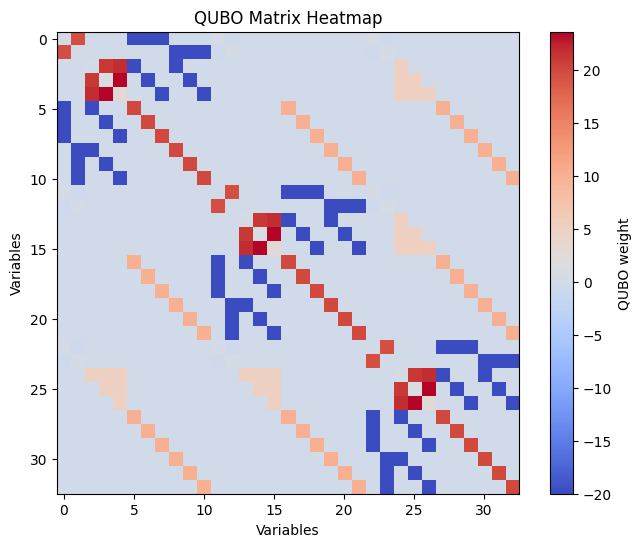

In [174]:

import matplotlib.pyplot as plt
df = qb.to_dataframe(use_labels=True)
plt.figure(figsize=(8, 6))
plt.imshow(df.values, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="QUBO weight")
plt.title("QUBO Matrix Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

In [168]:
from model.constraints import c5
import importlib
importlib.reload(c5)
precedence = [("T1", "T3"), ("T2", "T3")]

c5.add_c5_precedence_inline(qb, task, slot, y, precedence, lam_c5=5.0)

In [166]:
from model.objectives.balance import add_workload_balance_objective

add_workload_balance_objective(qb, task, amr, x, w_balance=0.5)

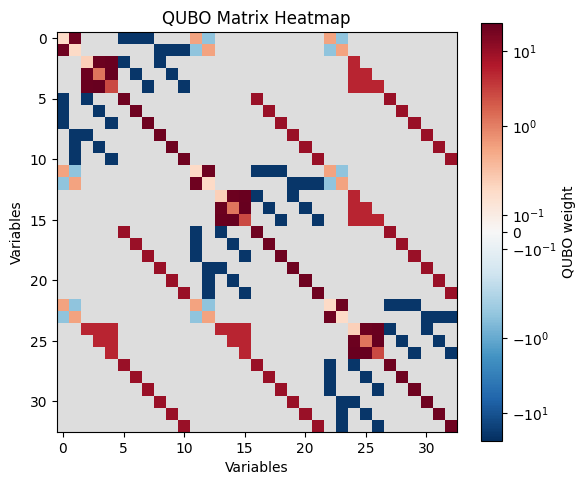

In [180]:
import plot_qb_heatmap
import importlib
importlib.reload(plot_qb_heatmap)

plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)



In [181]:
import numpy as np
df = qb.to_dataframe()
H_obj = df.filter(like='objective')  # falls du sie getaggt hast
print("QUBO absolute values:", np.percentile(np.abs(df.values), [5,50,95]))


QUBO absolute values: [ 0.  0. 20.]


In [182]:
import dimod, neal

In [190]:
Q = dict(qb.Q) 
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}


In [ ]:
bqm = dimod.BinaryQuadraticModel.from_qubo(Q_upper)


In [ ]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=2000, sweeps=5000, beta_range=(0.1, 5.0), seed=123)
print(sampleset)

In [193]:
asym = [((i,j), w - Q.get((j,i),0.0)) for (i,j), w in Q.items() if i>j and abs(w - Q.get((j,i),0.0))>1e-9]
print("Asymmetrien:", len(asym))

Asymmetrien: 0


In [203]:
from decode_best_solution import invert_map, decode_sample

inv_x = invert_map(x)        # idx -> (tname, rname)
inv_y = invert_map(y)        # idx -> (tname, z)
inv_w = invert_map(w)    

sample = {int(k): int(v) for k, v in sampleset.first.sample.items()}
chosen_x, chosen_y, chosen_w = decode_sample(sample, inv_x, inv_y, inv_w)
print("X=1:", chosen_x)
print("Y=1:", chosen_y)
print("W=1:", chosen_w)

X=1: [('x', 'T1', 'R1'), ('x', 'T2', 'R2'), ('x', 'T3', 'R1'), ('x', 'T3', 'R2')]
Y=1: [('y', 'T1', 0), ('y', 'T2', 0), ('y', 'T3', 1), ('y', 'T3', 2)]
W=1: [('w', 'T1', 'R1', 0), ('w', 'T2', 'R2', 0), ('w', 'T3', 'R1', 1), ('w', 'T3', 'R1', 2), ('w', 'T3', 'R2', 1), ('w', 'T3', 'R2', 2)]
